In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import cPickle as pickle
from scipy.special import expit, logit

sns.set()

In [73]:
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
          'axes.labelweight': 'bold',
         'axes.titlesize':'x-large',
          'axes.titleweight': 'bold',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [74]:
COST_FOR_SICK = 10000 # per year
COST_FOR_HEALTHY = 500 # per year
SICKNESS_PREVALENCE = 5 # percent

In [75]:
%%latex
total_cost_because_of_sick = FN * cost_per_sick =

= total_positives * (1 - tpr) * cost_per_sick =

= N * prevalence * (1 - tpr) * cost_per_sick


total_cost_because_of_healthy = TN * cost_per_health = 

= total_negatives * (1 - fpr) * cost_per_healthy =

= N * (1 - prevalence) * (1 - fpr) * cost_per_healthy

<IPython.core.display.Latex object>

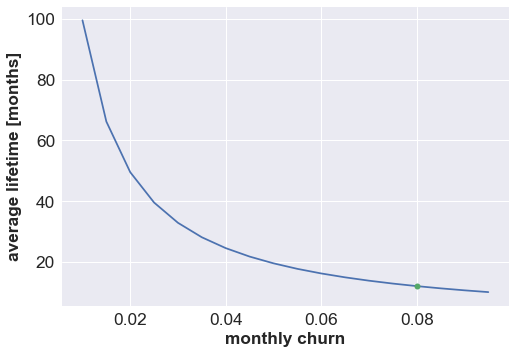

In [76]:
x = np.arange(0.01, 0.1, 0.005)
y = average_life_time_in_months(x)
x_one_year = x[np.where(y <= 12)[0][0]]
plt.plot(x, y)
plt.plot(x_one_year, 12, '.', ms=12)
plt.xlabel('monthly churn')
plt.ylabel('average lifetime [months]')
plt.show()

In [94]:
def average_cost_correctly_classified_healthy(p, fpr, cost_per_healthy):
    return (1 - p) * (1 - fpr) * cost_per_healthy

def average_cost_misclassified_sick(p, tpr, cost_per_sick):
    return p * (1 - tpr) * cost_per_sick

def total_enrolled(p, fpr, tpr):
    total_sick_enrolled = p * (1 - tpr)
    total_healthy_enrolled = (1 - p) * (1 - fpr)
    return total_sick_enrolled + total_healthy_enrolled

def average_premium_to_break_even(fpr, 
                                  tpr, 
                                  cost_for_sick=COST_FOR_SICK, 
                                  cost_for_healthy=COST_FOR_HEALTHY, 
                                  p=SICKNESS_PREVALENCE):
    cost = average_cost_misclassified_sick(p, tpr, cost_for_sick)
    cost += average_cost_correctly_classified_healthy(p, fpr, cost_for_healthy)
    premium = cost / total_enrolled(p, fpr, tpr) / 12
    if isinstance(fpr, numpy.ndarray):
        premium[(tpr < fpr) | (tpr < 0.2)] = NaN
    return premium

def average_life_time_in_months(monthly_churn):
    # survival is modelled as an exponential distribution
    # where survival probability after one month = 1 - monthly_churn
    # and survival probability = exp(-lambda * x)
    # which gives us exp(-lambda * 1) = 1 - monthly_churn
    # or lambda = -log(1 - monthly_churn)
    # the mean of the exp dist is given by 1 / lambda
    lambda_ = -np.log(1 - monthly_churn)
    return 1.0 / lambda_

def life_time_value(daily_premium, monthly_churn):
    return daily_premium * 30 * average_life_time_in_months(monthly_churn)

def revenue_per_enrolled(daily_premium, monthly_churn):
    if monthly_churn is None:
        # return one year's income
        return daily_premium * 365
    else:
        assert 0 <= monthly_churn <= 1
        return life_time_value(daily_premium, monthly_churn)
        
def profit_per_patient(fpr, 
                       tpr, 
                       daily_premium,
                       cac=0,
                       cost_for_sick=COST_FOR_SICK, 
                       cost_for_healthy=COST_FOR_HEALTHY, 
                       p_in_percent=SICKNESS_PREVALENCE,
                       monthly_churn=None):
    # all values normalized to one person
    p = p_in_percent / 100.0
    cost_per_person = cac
    cost_per_person += average_cost_misclassified_sick(p, tpr, cost_for_sick)
    cost_per_person += average_cost_correctly_classified_healthy(p, fpr, cost_for_healthy)
    n_enrolled = total_enrolled(p, fpr, tpr)
    revenue_per = revenue_per_enrolled(daily_premium, monthly_churn)
    profit_per_person = n_enrolled * revenue_per - cost_per_person
    if isinstance(fpr, np.ndarray):
        profit_per_person[(tpr < fpr)] = np.NaN
    return profit_per_person

def from_4_cats_to_2(cs, ps):
    assert len(cs) == 4
    assert len(ps) == 4
    if cs != sorted(cs):
        print "costs and prevalences must be from healthiest to sickest"
        return 0, 0, 0
    
    cost_for_healthy = cs[0] * ps[0] + cs[1] * ps[1]
    if cost_for_healthy > 0:
        cost_for_healthy /= (ps[0] + ps[1])
    cost_for_sick = cs[2] * ps[2] + cs[3] * ps[3] 
    if cost_for_sick > 0:
        cost_for_sick /= (ps[2] + ps[3])
    p_sick = ps[2] + ps[3]
    return cost_for_healthy, cost_for_sick, p_sick

def profit_per_patient_4_cats(fpr, 
                       tpr, 
                       daily_premium,
                       cac,
                       costs,
                       prevalences):
    cost_for_healthy, cost_for_sick, p_sick = from_4_cats_to_2(costs, prevalences)
    ppp = profit_per_patient(fpr, tpr, daily_premium, cac, cost_for_sick, cost_for_healthy, p_sick * 100)
    return cost_for_healthy, cost_for_sick, p_sick, ppp

In [78]:
def small_mock_unit_tests():
    # fpr == 0 means no healthy patient is denied insurance
    # tpr == 0 means all exploding patients are insured
    assert total_enrolled(p=0.1, fpr=0, tpr=0) == 1.0
    x = profit_per_patient(fpr=0, 
                          tpr=0, 
                          daily_premium=1000.0/365, 
                          cost_for_sick=100, 
                          cost_for_healthy=1, 
                          p_in_percent=10)
    assert x == 1000 - 10 - 0.9, x
    
    # fpr == 0 means no healthy patient is denied insurance
    # tpr == 1 means all exploding patient are denied insurance
    assert total_enrolled(p=0.1, fpr=0, tpr=1) == 0.9
    x = profit_per_patient(fpr=0, 
                          tpr=1, 
                          daily_premium=1000.0/365, 
                          cost_for_sick=100, 
                          cost_for_healthy=1, 
                          p_in_percent=10)
    assert x == 900 - 0.9, x
    
    # fpr == 1 means all healthy patients are denied insurance
    # tpr == 1 means all exploding patients are denied insurance
    assert total_enrolled(p=0.1, fpr=1, tpr=1) == 0
    x = profit_per_patient(fpr=1, tpr=1, daily_premium=1000.0/365)
    assert x == 0, x
    
    assert total_enrolled(p=0.1, fpr=0, tpr=1) == 0.9
    x = profit_per_patient(fpr=0, 
                          tpr=1,
                          cac=5,
                          daily_premium=1000.0/365, 
                          cost_for_sick=100, 
                          cost_for_healthy=1, 
                          p_in_percent=10)
    assert x == 900 - 0.9 - 5, x
    
small_mock_unit_tests()

In [79]:
import matplotlib.colors as colors

cm = plt.get_cmap('RdYlGn')
c_norm = colors.Normalize(vmin=-500, vmax=500)

In [80]:
from ipywidgets import interact, FloatSlider, IntSlider
from scipy.interpolate import interp1d

In [81]:
def auc_to_roc(auc, x=np.arange(0, 1, 0.01)):
    # ax^2 + bx + c = 0
    # passing through (0,0) and (1,1)
    # with the integral equaling auc
    return (3 - 6 * auc) * x * x + (6 * auc - 2) * x

In [82]:
our_roc = pickle.load(open('./actuary_files/our_roc_hhp.pickle'))

In [89]:
def plot_one_roc(auc, xvec, label):
    plt.plot(xvec, auc_to_roc(auc, xvec), '--', alpha=0.7, label=label)
    
def plot_hosp_heart_disease():
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4314395/ ; figure 3
    points = [(0, 0), (0.04, 0.475), (0.05, 0.51), (0.09, 0.6),
                (0.11, 0.64), (0.15, 0.69), (0.2, 0.74),
                (0.28, 0.8), (0.36, 0.85), (0.48, 0.89), (0.56, 0.91),
                (0.68, 0.94), (0.8, 0.96), (1,1)]
    x, y = zip(*points)
    f = interp1d(x, y)
    xvec = np.linspace(0, 1, 100)
    plt.plot(xvec, f(xvec), 'b--', alpha=0.7, label='hosp_hd 0.82')
    
def plot_our_hhp():
    plt.plot(our_roc[0], our_roc[1], 'k-', alpha=0.7, label='our HHP')
    
def plot_all_research():
    xvec = np.linspace(0, 1, 50)
    
    plot_one_roc(0.77, xvec, 'stroke auc=0.77')
    
    plot_hosp_heart_disease()
    
    plot_our_hhp()

    # Recurrent stroke predictions
    # https://bmcmedicine.biomedcentral.com/articles/10.1186/1741-7015-12-58

    # ESSEN stroke risk score
    plot_one_roc(0.6, xvec, 'ESRS auc=0.60')

    # Stroke Prognosis Instrument II (SPI-II)
    plot_one_roc(0.62, xvec, 'SPI-II auc=0.62')

    # Recurrence Risk Estimator at 90 days (RRE-90)
    plot_one_roc(0.72, xvec, 'RRE-90 (A1) auc=0.72')
    plot_one_roc(0.59, xvec, 'RRE-90 (A2) auc=0.59')
    plot_one_roc(0.75, xvec, 'RRE-90 (B) auc=0.75')

    # Life Long After Cerebral ischemia (LiLAC)
    plot_one_roc(0.65, xvec, 'LiLAC auc=0.65')

    # ABCD2 score
    plot_one_roc(0.60, xvec, 'ABCD2 (1) auc=0.60')
    plot_one_roc(0.62, xvec, 'ABCD2 (2) auc=0.62') 
    
    # Recurrent Cardiovascular Events
    plot_one_roc(0.632, xvec, 'Modified Essen Score (1) auc=0.632')
    plot_one_roc(0.64, xvec, 'Modified Essen Score (2) auc=0.640')

    plt.legend(loc='lower right')
    
# def life_time_value(monthly_churn):
    
    
class PrevalenceAdjuster:
    def __init__(self):
        self._ratios_race_gender = pickle.load(open('./actuary_files/race_gender_ratios.pickle'))
        
    def race_gender(self, race_gender):
        if race_gender == 'average distribution':
            return 1
        race_gender = race_gender.replace(' ', '_').replace('african-american', 'black')
        return self._ratios_race_gender.loc[race_gender]
    
class LordOfRegressions(object):
    def __init__(self, regression_results, feature_medians, feature_percentiles):
        self._regressions = regression_results
        self.medians = feature_medians
        self._percentiles = feature_percentiles

    def _logodds_mean_std(self, feature_values):
        res_in_logodds = []
        for reg_res in self._regressions:
            features_here = reg_res.index.values
            # the sum ignores nans (features not used in this regression)
            res_in_logodds.append((reg_res.coef * feature_values).sum()) 
        logodds_mean = np.array(res_in_logodds).mean()
        logodds_std = np.array(res_in_logodds).std()
        return logodds_mean, logodds_std
    
    def use_all_regressions_by_percentile(self, percentiles):
        if isinstance(percentiles, dict):
            percentiles = pd.Series(percentiles)     
        values = {k: self._percentiles[k][v] for k, v in percentiles.iteritems()}
        return self.use_all_regressions(values)

    def use_all_regressions(self, provided_features):
        if isinstance(provided_features, dict):
            provided_features = pd.Series(provided_features)

        # start with the medians (bias included)
        x = self.medians.copy()

        # plug in the values for the subset of the provided features
        for f, v in provided_features.iteritems():
            x.loc[f] = v

        # Run all the regressions with provided features
        logodds_user_mean, logodds_user_std = self._logodds_mean_std(x)

        # Run all the regressions with median values
        logodds_median_mean, logodds_median_std = self._logodds_mean_std(self.medians)

        # reference (disregard std?)
        median_percent = expit(logodds_median_mean)

        predicted_exact = expit(logodds_user_mean)
        predicted_high = expit(logodds_user_mean + logodds_user_std)
        predicted_low = expit(logodds_user_mean - logodds_user_std)

        ratio = predicted_exact / median_percent
        ratio_high = predicted_high / median_percent
        ratio_low = predicted_low / median_percent

        return ratio, ratio_high, ratio_low
    
def plot_profit_2_cats(daily_premium, 
                       cac, 
                       cost_for_sick, 
                       cost_for_healthy, 
                       base_prevalence, 
                       race_gender,
                       HS_diploma,
                       diabetes,
                       obesity,
                       poverty,
                       heart_disease,
                       span,
                       monthly_churn,
                       plot_research, 
                       case,
                       step):
    assert span in ['Life Time', 'One Year']
    plt.figure(figsize=(16, 8))
    xvec = np.linspace(0, 1, 50)                               
    x, y = np.meshgrid(xvec, xvec)
    
    values = dict(no_hsdip=100 - HS_diploma,
                 dm_prev_adj=diabetes,
                 ob_prev_adj=obesity,
                 povpct=poverty,
                 prev_hd=heart_disease)
    race_gender_ratio = prevalence_adjuster.race_gender(race_gender)
    other_ratio, other_ratio_high, other_ratio_low = lord_of_regressions.use_all_regressions_by_percentile(values)
    if case == 'normal':
        r = other_ratio
    elif case == 'best':
        r = other_ratio_low
    elif case == 'worst':
        r = other_ratio_high
    else:
        raise ValueError
    print 'race & gender ratio {:.2f}'.format(race_gender_ratio)
    print 'all other features ratio {:.2f}'.format(r)
    adjusted_prevalence = base_prevalence * race_gender_ratio * r
    
    z = profit_per_patient(x, y, daily_premium, cac, 
                           cost_for_sick, cost_for_healthy, adjusted_prevalence,
                           monthly_churn / 100.0 if span == 'Life Time' else None)
    v = range(int(np.nanmin(z))/step*step, int(np.nanmax(z))/step*step+step, step)
    cs = plt.contourf(x, y, z, v, cmap=cm, norm=c_norm, origin='lower') 
    cs2 = plt.contour(cs, levels=cs.levels[::2], colors='b', origin='lower')
    cbar = plt.colorbar(cs, norm=c_norm, shrink=0.9) 
    cbar.add_lines(cs2)

    if plot_research:
        plot_all_research()


    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    profit = 'Yearly profit' if span == 'One Year' else 'Life Time Value'
    s = '{} per patient\nBase Prevalence: {:.2f}%, Adjusted Prevalence {:.2f}%\n'.format(profit,
                                                                                         base_prevalence,
                                                                                         adjusted_prevalence)
    s += 'Yearly healthy cost {:.0f}, Yearly sick cost {:.0f}'.format(cost_for_healthy, cost_for_sick)
    plt.title(s)
    plt.ylim(0, 1)
    plt.show()
    
def plot_profit_4_cats(daily_premium, 
                       cac, 
                       cost0=0, 
                       cost1=1000,
                       p1=0.05, 
                       cost2=5000, 
                       p2=0.03, 
                       cost3=10000, 
                       p3=0.02,
                       **kwargs):
    xvec = np.linspace(0, 1, 50)                               
    x, y = np.meshgrid(xvec, xvec)
    c_h, c_s, p_s, z = profit_per_patient_4_cats(x, 
                                                 y, 
                                                 daily_premium, 
                                                 cac, 
                                                 [cost0, cost1, cost2, cost3], 
                                                 [(1-p1-p2-p3), p1, p2, p3])
    plot_profit_2_cats(daily_premium, cac, c_s, c_h, p_s, **kwargs)

In [84]:
prevalence_adjuster = PrevalenceAdjuster()

In [85]:
lord_of_regressions = pickle.load(open('./actuary_files/lord_of_regressions.pickle'))

In [86]:
medians = lord_of_regressions.medians

In [87]:
race_gender_options = ['average distribution', 
                    'white male', 
                    'white female', 
                    'african-american male', 
                    'african-american female', 
                    'hispanic female']

In [95]:
interact(plot_profit_2_cats, 
         daily_premium=FloatSlider(min=0, max=4, step=0.1, value=2),
         cac=IntSlider(min=0, max=300, step=50, value=150),
         cost_for_sick=IntSlider(min=0, max=15000, step=1000, value=7000),
         cost_for_healthy=IntSlider(min=0, max=500, step=100, value=100),
         base_prevalence=FloatSlider(min=0.1, max=3, step=0.1, value=1.5),
         race_gender=race_gender_options,
         HS_diploma=IntSlider(min=0, max=100, value=50),
         diabetes=IntSlider(min=0, max=100, value=50),
         obesity=IntSlider(min=0, max=100, value=50),
         poverty=IntSlider(min=0, max=100, value=50),
         heart_disease=IntSlider(min=0, max=100, value=50),
         span=['One Year', 'Life Time'],
         monthly_churn=IntSlider(min=1, max=20, step=1, value=8),
         case=['normal', 'best', 'worst'],
         plot_research=True,
         step=IntSlider(min=25, max=100, value=25, step=25))

<function __main__.plot_profit_2_cats>